Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /Users/sadegh/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/sadegh/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loading the dataset from Hugging Face...
Loaded 2 samples from the dataset.

Step 3: Creating a DataLoader to handle batches...
✓ BSDS500 loaded successfully
Running reconstruction for inpainting with DiffPIR...


DiffPIR:   0%|          | 0/200 [00:00<?, ?it/s]/Users/sadegh/Library/CloudStorage/GoogleDrive-sadeghsalehi1997@gmail.com/My Drive/Projects/Diffusion Inverse Problems/diffusion-inverse-problems/algorithms/diffpir.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_bar_next_tensor = torch.tensor(alpha_bar_next, device=device)
DiffPIR: 100%|██████████| 200/200 [00:28<00:00,  6.90it/s]


Running reconstruction for inpainting with DPS...


RePaint: 100%|██████████| 500/500 [05:50<00:00,  1.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07581872..1.0003502].


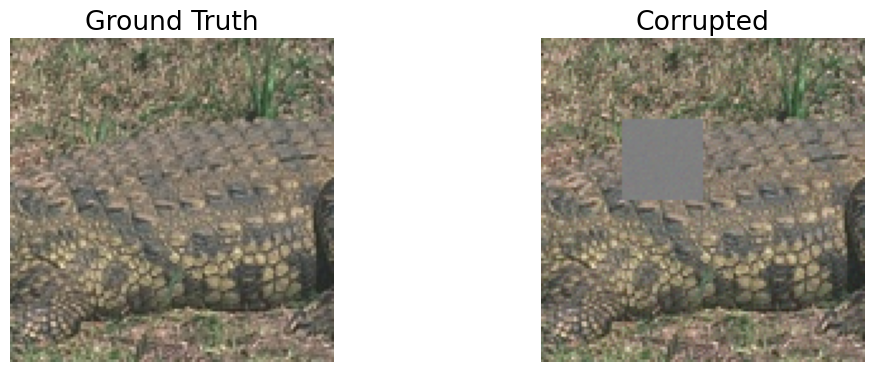

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/sadegh/opt/miniconda3/envs/deepinv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sadegh/opt/miniconda3/envs/deepinv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/sadegh/opt/miniconda3/envs/deepinv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.023920808..1.0003502].


Evaluation Results:
DiffPIR - PSNR: 32.7248
DiffPIR - SSIM: 0.9376
DiffPIR - LPIPS: 0.0610
DiffPIR - FID: 25.9672
DPS - PSNR: 25.7487
DPS - SSIM: 0.7909
DPS - LPIPS: 0.1549
DPS - FID: 28.8016
DDRM - PSNR: 25.8873
DDRM - SSIM: 0.9301
DDRM - LPIPS: 0.1144
DDRM - FID: 29.0846
Repaint - PSNR: 31.4986
Repaint - SSIM: 0.9321
Repaint - LPIPS: 0.0210
Repaint - FID: 27.9116


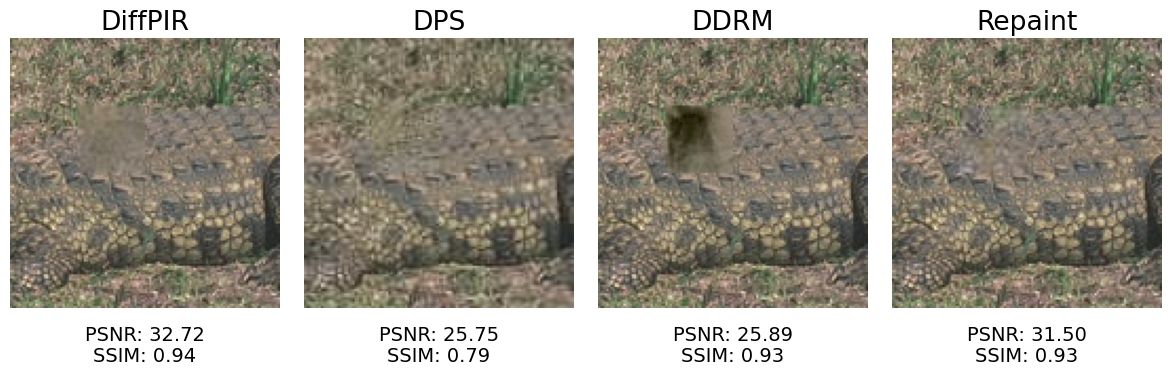

In [ ]:
import torch
import numpy as np
from diffusers import DDPMPipeline
import sys, os
# Adding project root (parent of notebooks/) to Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
# === Imports from Repo ===
from algorithms.diffpir import diffpir
from algorithms.dps import dps
from algorithms.repaint import repaint
from algorithms.ddrm import ddrm_ddim, ddrm_ddpm
from utils.dataset import get_pipeline_and_dataset
from utils.degrade import degrade_dataloader
from utils.visualization import show_images
from utils.metrics import MetricsEvaluator
import deepinv as dinv
from physics.inpainting import InpaintingProblem


# === Device Selection ===
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)


# === Load Pipeline and Dataset ===
pipeline, dataloader = get_pipeline_and_dataset(
    model_name="google/ddpm-celebahq-256",
    dataset_name="BSDS500",   # options: "CT", "CelebA-HQ", ...
    batch_size=1,
    img_size=128,
    subset_ratio=0.01,
    device=device
)


# === Problem Selection ===
problem = "inpainting"  # options: "inpainting", "CT", "blur_Gaussian", "blur_motion"
img_size = (3, 128, 128)
noise_level = 0.02

if problem == "inpainting":
    mask = torch.ones(1, img_size[1], img_size[2])
    mask[:, 32:64, 32:64] = 0
    physics = InpaintingProblem(img_size=img_size, mask=mask, device=device)

elif problem == "CT":
    angles = 100
    physics = dinv.physics.Tomography(
        img_width=img_size[1],
        angles=angles,
        circle=False,
        device=device,
    )

elif problem == "blur_Gaussian":
    kernel = dinv.physics.blur.gaussian_blur(sigma=(1.0, 1.0), angle=0.0)
    physics = dinv.physics.Blur(kernel, device=device, padding="replicate")

elif problem == "blur_motion":
    kernel = dinv.physics.blur.gaussian_blur(sigma=(2, 0.1), angle=0.0)
    physics = dinv.physics.Blur(kernel, device=device, padding="replicate")

else:
    raise ValueError(f"Unknown problem type: {problem}")


# === Define Forward and Pseudo-inverse Operators ===
A, A_pinv = physics.A, physics.A_dagger


# === Corrupt Dataset ===
noisy_dataloader = degrade_dataloader(dataloader, A, noise_std=noise_level, device=device)


# === Load One Sample (clean + corrupted) ===
sample_clean = next(iter(dataloader))
clean_img = sample_clean["image"].to(device) if isinstance(sample_clean, dict) else sample_clean[0].to(device)

sample_noisy = next(iter(noisy_dataloader))
y = sample_noisy[0].to(device)

show_images(
    [clean_img, y],
    titles=["Ground Truth", "Corrupted"]
)

# === Run DiffPIR ===
print(f"Running reconstruction for {problem} with DiffPIR...")
reconstructed_diffpir = diffpir(
    pipeline=pipeline,
    y=y,
    A=A,
    A_pinv=A_pinv,
    sigma_n=noise_level,
    num_inference_steps=200,
)

# rescale [-1,1] to [0,1]
clean_img = (clean_img + 1) / 2
reconstructed_diffpir = (reconstructed_diffpir + 1) / 2
y = (y + 1) / 2



# === Run DPS ===
print(f"Running reconstruction for {problem} with DPS...")
reconstructed_dps = dps(
    pipeline=pipeline,
    y=y,
    A=A,
    A_pinv=A_pinv,
    num_steps=200,
    eta=0.0,
    zeta=0.5,
    gt=clean_img,
    verbose=False
)

# === Run DDRM ===
reconstructed_ddrm = ddrm_ddim(
    pipeline=pipeline,
    y=y,
    A=A,
    A_pinv=A_pinv,
    num_inference_steps=10,
)

# === Run Repaint ===
reconstructed_repaint = repaint(
    pipeline=pipeline,
    corrupted_img=y,
    mask=mask.to(device),
    num_inference_steps=500,
    jump_n_sample=10
)

# === Visualization ===
evaluator = MetricsEvaluator(device=device)

results_diffpir = evaluator.compute_all(reconstructed_diffpir, clean_img)
results_dps = evaluator.compute_all(reconstructed_dps, clean_img)
results_ddrm = evaluator.compute_all(reconstructed_ddrm, clean_img)
results_repaint = evaluator.compute_all(reconstructed_repaint, clean_img)

print("Evaluation Results:")
for k, v in results_diffpir.items():
    print(f"DiffPIR - {k}: {v:.4f}")
for k, v in results_dps.items():
    print(f"DPS - {k}: {v:.4f}")
for k, v in results_ddrm.items():
    print(f"DDRM - {k}: {v:.4f}")
for k, v in results_repaint.items():
    print(f"Repaint - {k}: {v:.4f}")

show_images([reconstructed_diffpir, reconstructed_dps, reconstructed_ddrm, reconstructed_repaint], titles=["DiffPIR", "DPS", "DDRM", "Repaint"], metrics=[
        {"PSNR": results_diffpir["PSNR"], "SSIM": results_diffpir["SSIM"]},
        {"PSNR": results_dps["PSNR"], "SSIM": results_dps["SSIM"]},
        {"PSNR": results_ddrm["PSNR"], "SSIM": results_ddrm["SSIM"]},
        {"PSNR": results_repaint["PSNR"], "SSIM": results_repaint["SSIM"]}
    ])
